## Model description 

This model takes all words from the headlines in one day and extracts the sentiment as the elementwise addition of the word embeddings for that day. Each dimension of the embedding is then weighted and combined with an ARIMA-prediction of the value 'delay' days ahead.


In [1]:
from tensorflow.keras.layers import Embedding, Dense, Input
from tensorflow.keras.models import Model
from nltk import word_tokenize
from pathlib import Path
import matplotlib.pyplot as plt
import gensim
import numpy as np
import pandas as pd 
import os
import io
import pickle
import random
import itertools
from importnb import Notebook, reload
with Notebook(): 
    import Utilities

In [2]:
def preprocess_text(df):
    """ Tokenize """
    conc = pd.DataFrame()
    for i in set(df.index):
        concat_str = ''
        for title in df.loc[i]['title']:
            concat_str += " " + title.lower()
        concat_str = word_tokenize(concat_str)
        conc = conc.append({'date':i, 'title':concat_str},ignore_index=True)
    conc.set_index('date',inplace=True)
    conc = conc.sort_values('date')
    return conc

def title2vec(data, emb_dict,index): 
    """Embed a title with an arbitrary number of words to a vector 
     with shape(d), where d is the dimension of the embedding. """
    d = 300
    x = np.zeros((len(data), d))
    for i,row in enumerate(data.values): 
        n = 0
        temp = np.zeros(d)
        for word in row[0]: 
            if word in emb_dict.keys(): 
                n += 1
                temp = np.add(temp, emb_dict.get(word))
        x[i] = temp / n
    return x

In [3]:
config = {
    'start_date': '2006-10-20',
    'end_date': '2013-11-19',
    'lookback': 1,       # Using lookback > 1 is not yet implemented
    'delay': 5,
    'p': 1,
    'd': 1,
    'q': 1,
    'series': '1 YEAR',
}

In [10]:
os.getcwd()

'C:\\Users\\gusta\\Documents\\Skola\\Lund\\Indek år 5\\Exjobb\\Repos\\NLP-finance\\Regression'

In [30]:
# Load data 
news_path = Path("../Datasets/data/financial_headlines_20061020-20131119.pkl")
stock_path = Path("../Datasets/data/stock_data.pkl")
news_data = pd.DataFrame(pd.read_pickle(news_path))
news_data.set_index('date',inplace=True)
stock_data = pd.DataFrame(pd.read_pickle(stock_path))
# Tokenize
data = preprocess_text(news_data)

In [31]:
# Load dictionary of embeddings for this vocabulary (previously constructed)
subset_embeddings = Path("../Embeddings/GloVe/saved.42B.300d.pkl")
with open(subset_embeddings,'rb') as handle: 
    emb_dict = pickle.load(handle)

In [32]:
# Create an index mapping for all words in the vocabulary
word_index = {}
i = 1
for word in emb_dict.keys(): 
    word_index.update({word:i})
    i += 1

In [33]:
unique_words = set() 
for title in data['title']:
    for word in title: 
        unique_words.add(word)
print("Total vocabulary size:",len(unique_words))
print("Words not included in GloVe:",len(unique_words) - len(emb_dict))


Total vocabulary size: 29083
Words not included in GloVe: 2850


In [34]:
# Transform the data to the average word embedding each day
x = title2vec(data,emb_dict,word_index)

# Format financial data and interpolate missing values
fin_data, fin_stats = Utilities.format_financial_data(stock_data, data.index, config['start_date'], config['end_date'])

In [35]:
# Check if the ARIMA-models has been previously calculated for this config
# or if they have to be constructed
path = Path(f"../Models/ARIMA/all_mods_del{config['delay']}.pkl")
if os.path.exists(path):
    # Load model if it already exists
    ARIMA_models = pd.read_pickle(path)
    print("Found and loaded previously constructed models.")
else: 
    # Fit ARIMA-models to all of the dates in the training data 
    print("Model not found, fitting models. ")
    ARIMA_models = Utilities.fit_all_models(config, fin_data)
    ARIMA_models.to_pickle(path)

Found and loaded previously constructed models.


In [36]:
# Generate predictions from the fitted ARIMA-models
arima_preds = Utilities.predict_arima(ARIMA_models, config['delay'])

In [37]:
# Drop the values not in arima_preds. This is just values in the beginning where
# there isn't enough data to make a prediction, varies depending on lookback and delay. 
for date in fin_data.index: 
    if not date in arima_preds.index : fin_data.drop(index=date,inplace=True)

In [38]:
# Create a target feature which is simply the deviance between actual value in 
# delay days and the predicted value 
y = np.zeros(len(fin_data) - config['delay'])
for i in range(len(y)):
    y[i] = arima_preds[config['series']].iloc[i] - fin_data[config['series']].iloc[i + config['delay']]

In [39]:
# Need to remove some rows from the word embedding-matrix,
# these numbers are specified in Utilities.fit_all_models()
rm_start_rows = max(config['lookback'],5) + 1
rm_end_rows = config['delay']
x = x[rm_start_rows : -rm_end_rows]

In [40]:
(x_train,y_train), (x_test, y_test) = Utilities.shuffle_and_partition(x,y, test_part=0.2)

In [41]:
print("Shape of x_train: ",x_train.shape)
print("Shape of y_train: ",y_train.shape)

Shape of x_train:  (2056, 300)
Shape of y_train:  (2056,)


## Model construction 

We'll do a simple hyper parameter optimization including batch size, number of layers and numer of nodes per layer. 

In [16]:
def create_nn(n_nodes, activation='relu'): 
    # n_nodes is a list with the number of nodes per layer, starting from the input 
    input_layer = Input(shape=300, name='input')
    prev_layer = input_layer
    for n in n_nodes: 
        prev_layer = Dense(n, activation=activation)(prev_layer)
    output_layer = Dense(1, activation='linear', name='output')(prev_layer)
    
    model = Model(inputs =[input_layer], outputs=[output_layer])
    model.compile(optimizer='rmsprop', loss='mse')
    return model

def train_and_format(x,y,bs,epochs, results, layers, nodes):
    name = f"{bs}_{layers}_{nodes}"
    temp_history = model.fit(x, y, batch_size=bs, validation_split=0.2, epochs = epochs,verbose=0)
    return results.append(pd.Series([np.mean(temp_history.history['val_loss'][-5:]),
                                                temp_history, model, layers, 
                                                nodes, bs], 
                                                name=name,index=['Mean Val MSE','History','Model','Layers','Nodes','Batch Size']))


In [25]:
n_layers = np.arange(2,3)
n_nodes = [25, 50, 75, 100, 200, 300, 400, 500]
batch_sizes = [8, 12, 16]
epochs = 10
results = pd.DataFrame(columns=['Mean Val MSE','History','Model', 'Layers', 'Nodes','Batch Size'])
n_configs = sum([len(n_nodes)**l for l in n_layers]) * len(batch_sizes)
ctr = 0
print('Testing {} combinations. '.format(n_configs))
for layers in n_layers:
    if layers == 1: node_configs = list(itertools.product(n_nodes))
    elif layers == 2: node_configs = list(itertools.product(n_nodes, n_nodes))
    elif layers == 3: node_configs = list(itertools.product(n_nodes, n_nodes, n_nodes))
    elif layers == 4: node_configs = list(itertools.product(n_nodes, n_nodes, n_nodes, n_nodes))
    for bs in batch_sizes: 
        for temp_nodes in node_configs: 
            ctr += 1 
            print("{} %     ".format(round(100 * ctr / n_configs,2)),end='\r')
            model = create_nn(temp_nodes)
            results = train_and_format(x_train, y_train, bs, epochs, results, layers, temp_nodes)
            
            

Testing 192 combinations. 


In [24]:
k = 20
print("Top {} configs: ".format(k))
k_best = np.argpartition(results['Mean Val MSE'],k)[:k]
k_best = pd.DataFrame(results.iloc[k_best])
k_best

Top 20 configs: 


,Mean Val MSE,History,Model,Layers,Nodes,Batch Size
"16_2_(200, 25)",0.000217,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.training.Model...,2,"(200, 25)",16
"8_2_(500, 50)",0.000221,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.training.Model...,2,"(500, 50)",8
"8_2_(400, 25)",0.000216,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.training.Model...,2,"(400, 25)",8
"8_2_(300, 25)",0.000218,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.training.Model...,2,"(300, 25)",8
"16_2_(400, 25)",0.000216,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.training.Model...,2,"(400, 25)",16
"12_2_(50, 300)",0.000219,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.training.Model...,2,"(50, 300)",12
"16_2_(500, 25)",0.000218,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.training.Model...,2,"(500, 25)",16
"8_2_(500, 25)",0.000222,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.training.Model...,2,"(500, 25)",8
"8_2_(25, 500)",0.000224,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.training.Model...,2,"(25, 500)",8
"8_2_(400, 75)",0.000222,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.training.Model...,2,"(400, 75)",8


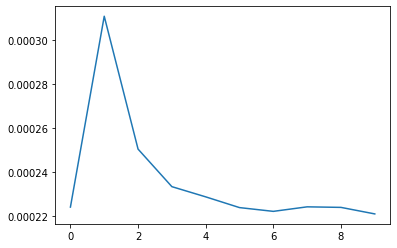

3lay300nodes128bs


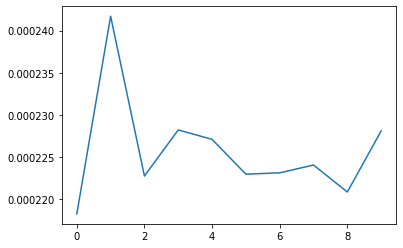

2lay300nodes64bs


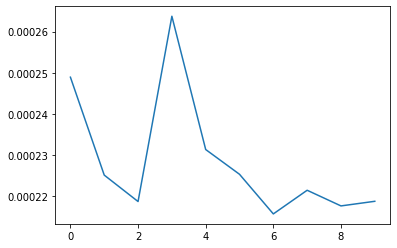

3lay100nodes8bs


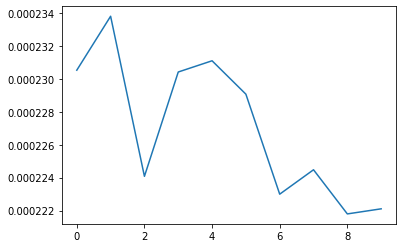

3lay500nodes64bs


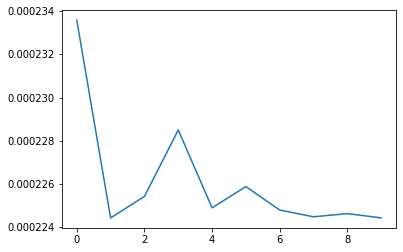

3lay75nodes16bs


In [56]:
k = 5
k_best = np.argpartition(results['Mean Val MSE'],k)[:k]
for i in k_best: 
    plt.plot(results.iloc[i]['History'].history['val_loss'])
    plt.show()
    print(results.index[i])


In [43]:
best = np.argpartition(results['Mean Val MSE'],1)[1]
model_test = results.iloc[best]['Model'].evaluate(x_test,y_test,verbose=0)
zero_test = np.dot(y_test,y_test) / len(y_test)
print("Model test score:",model_test)
print("Zero test score:",zero_test)

Model test score: 0.0003197104006335173
Zero test score: 0.00032025349693868817
